In [ ]:
# loading libraries
import re
import os
import pickle
from pprint import pprint

import matplotlib.pyplot as plt
import pandas as pd

import nltk
nltk.download('stopwords')
nltk.download('all')
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess

import pyLDAvis
import pyLDAvis.gensim

# disable all warnings
import warnings
warnings.filterwarnings("ignore")

In [406]:
#importing data
df=pd.read_csv('data_lt.csv')
df

,type,id,title,text,created,parent_id
0,post,y87kyp,UK leader Liz Truss loses second minister,NaN,10/19/22 19:41,NaN
1,comment,isyoxry,NaN,That’s the lovely lady who said her “dream” wa...,10/19/22 20:47,y87kyp
2,comment,isyfy4g,NaN,NaN,10/19/22 19:49,y87kyp
3,comment,isyg4i7,NaN,Please let this wake the UK up to how inept th...,10/19/22 19:50,y87kyp
4,comment,isyg3aa,NaN,What’s the record for shortest PM tenure?,10/19/22 19:50,y87kyp
...,...,...,...,...,...,...
2068,comment,inanvpd,NaN,It makes them more of a speedbump than an actu...,9/6/22 13:12,x6oz95
2069,comment,inbfmvn,NaN,"It criticises and amends legislation, and norm...",9/6/22 17:25,x6oz95
2070,comment,in9j9lu,NaN,"Australia does it too, as well as Belize, Cana...",9/6/22 5:28,x6oz95
2071,comment,inbg06k,NaN,Another proposal is make the chamber operate o...,9/6/22 17:27,x6oz95


In [407]:
#remove unwanted columns
df= df[df.columns[3:5]]
df

,text,created
0,NaN,10/19/22 19:41
1,That’s the lovely lady who said her “dream” wa...,10/19/22 20:47
2,NaN,10/19/22 19:49
3,Please let this wake the UK up to how inept th...,10/19/22 19:50
4,What’s the record for shortest PM tenure?,10/19/22 19:50
...,...,...
2068,It makes them more of a speedbump than an actu...,9/6/22 13:12
2069,"It criticises and amends legislation, and norm...",9/6/22 17:25
2070,"Australia does it too, as well as Belize, Cana...",9/6/22 5:28
2071,Another proposal is make the chamber operate o...,9/6/22 17:27


In [408]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2073 entries, 0 to 2072
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     1997 non-null   object
 1   created  2073 non-null   object
dtypes: object(2)
memory usage: 32.5+ KB


In [409]:
# convert "created" to datetime
df['created'] = pd.to_datetime(df['created'])
df.fillna('', inplace=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2073 entries, 0 to 2072
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   text     2073 non-null   object        
 1   created  2073 non-null   datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 32.5+ KB


In [410]:
stop_words = []
with open('SmartStoplist.txt', "r") as f:
    for line in f:
        stop_words.extend(line.split())

def preprocess(raw_text):
    # regular expression keeping only letters
    letters_only_text = re.sub("[^a-zA-Z]", " ", raw_text)

    # convert to lower case and split into words -> convert string into list
    words = letters_only_text.lower().split()

    cleaned_words = []
    lemmatizer = PorterStemmer()

    # remove stopwords
    for word in words:
        if word not in stop_words:
            cleaned_words.append(word)

    # stemming
    stemmed_words = []
    for word in cleaned_words:
        word = lemmatizer.stem(word)
        stemmed_words.append(word)

    # converting list back to string
    return " ".join(stemmed_words)

In [411]:
df['prep'] = df['text'].apply(preprocess)
df

,text,created,prep
0,,2022-10-19 19:41:00,
1,That’s the lovely lady who said her “dream” wa...,2022-10-19 20:47:00,that s the love ladi who said her dream wa to ...
2,,2022-10-19 19:49:00,
3,Please let this wake the UK up to how inept th...,2022-10-19 19:50:00,pleas let thi wake the uk up to how inept the ...
4,What’s the record for shortest PM tenure?,2022-10-19 19:50:00,what s the record for shortest pm tenur
...,...,...,...
2068,It makes them more of a speedbump than an actu...,2022-09-06 13:12:00,it make them more of a speedbump than an actua...
2069,"It criticises and amends legislation, and norm...",2022-09-06 17:25:00,it criticis and amend legisl and normal the co...
2070,"Australia does it too, as well as Belize, Cana...",2022-09-06 05:28:00,australia doe it too as well as beliz canada p...
2071,Another proposal is make the chamber operate o...,2022-09-06 17:27:00,anoth propos is make the chamber oper on sorti...


In [412]:
# delete rows where prep is empty
df = df[df['prep'] != '']
df

,text,created,prep
1,That’s the lovely lady who said her “dream” wa...,2022-10-19 20:47:00,that s the love ladi who said her dream wa to ...
3,Please let this wake the UK up to how inept th...,2022-10-19 19:50:00,pleas let thi wake the uk up to how inept the ...
4,What’s the record for shortest PM tenure?,2022-10-19 19:50:00,what s the record for shortest pm tenur
5,"The rats are trying to leave the sinking ship,...",2022-10-19 19:57:00,the rat are tri to leav the sink ship now all ...
6,"Wait, she left voluntarily? I'd figure after t...",2022-10-19 20:04:00,wait she left voluntarili i d figur after the ...
...,...,...,...
2068,It makes them more of a speedbump than an actu...,2022-09-06 13:12:00,it make them more of a speedbump than an actua...
2069,"It criticises and amends legislation, and norm...",2022-09-06 17:25:00,it criticis and amend legisl and normal the co...
2070,"Australia does it too, as well as Belize, Cana...",2022-09-06 05:28:00,australia doe it too as well as beliz canada p...
2071,Another proposal is make the chamber operate o...,2022-09-06 17:27:00,anoth propos is make the chamber oper on sorti...


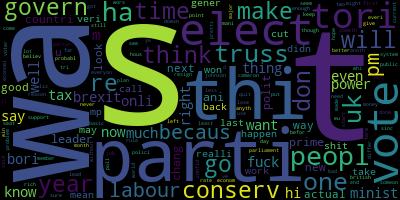

In [413]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(df['prep'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud=WordCloud(collocations=False).generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

In [414]:
# what kind of different words that are close to each other.
stop_words = stopwords.words('english')

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc))
             if word not in stop_words] for doc in texts]

data = df.prep.values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)

# printing top 20 words in the list in descending order

print(sorted(data_words[:1][0], key=lambda x: x[1], reverse=True)[:20])


['rwanda', 'full', 'dream', 'love', 'plane', 'fled', 'uk', 'see', 'refuge', 'refuge', 'kenya', 'ladi', 'said', 'wa', 'take', 'daughter']


In [415]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)


# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_words]

# View
print(corpus[:1][0][:30])

#use the above words to create a dictionary
#index and frequency

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1)]


In [416]:
# how many times each word appears in the document
[[(id2word[i], freq) for i, freq in doc] for doc in corpus[:1]]

[[('daughter', 1),
  ('dream', 1),
  ('fled', 1),
  ('full', 1),
  ('kenya', 1),
  ('ladi', 1),
  ('love', 1),
  ('plane', 1),
  ('refuge', 2),
  ('rwanda', 1),
  ('said', 1),
  ('see', 1),
  ('take', 1),
  ('uk', 1),
  ('wa', 1)]]

In [417]:
# number of topics
num_topics = 5

# Build LDA model
lda_model = gensim.models.LdaMulticore(
    corpus=corpus,
    id2word=id2word,
    num_topics=num_topics,
)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.014*"thi" + 0.012*"vote" + 0.008*"parti" + 0.007*"peopl" + 0.007*"wa" + '
  '0.007*"get" + 0.006*"truss" + 0.006*"ha" + 0.006*"go" + 0.005*"would"'),
 (1,
  '0.012*"elect" + 0.010*"parti" + 0.009*"thi" + 0.009*"wa" + 0.008*"vote" + '
  '0.007*"tori" + 0.007*"hi" + 0.006*"truss" + 0.006*"govern" + 0.006*"bori"'),
 (2,
  '0.013*"parti" + 0.010*"ha" + 0.010*"thi" + 0.007*"tori" + 0.007*"elect" + '
  '0.007*"wa" + 0.007*"would" + 0.006*"think" + 0.006*"peopl" + 0.005*"get"'),
 (3,
  '0.013*"tori" + 0.012*"parti" + 0.011*"wa" + 0.011*"like" + 0.010*"vote" + '
  '0.008*"thi" + 0.007*"elect" + 0.007*"becaus" + 0.006*"uk" + 0.006*"peopl"'),
 (4,
  '0.022*"wa" + 0.011*"elect" + 0.011*"would" + 0.010*"thi" + 0.008*"uk" + '
  '0.008*"like" + 0.008*"parti" + 0.007*"one" + 0.006*"get" + 0.006*"peopl"')]


In [418]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join(f'ldavis_prepared_{num_topics}')

# this is a bit time consuming - make the if statement True
# if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, f'ldavis_prepared_{num_topics}.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.012319 -0.004439       1        1  30.012567
4      0.012960  0.006764       2        1  24.919755
1      0.034470 -0.006611       3        1  18.462050
0     -0.034454 -0.033116       4        1  14.117007
2     -0.025295  0.037402       5        1  12.488620, topic_info=       Term        Freq       Total Category  logprob  loglift
20      thi  351.000000  351.000000  Default  30.0000  30.0000
136      ha  193.000000  193.000000  Default  29.0000  29.0000
18    parti  374.000000  374.000000  Default  28.0000  28.0000
14       wa  452.000000  452.000000  Default  27.0000  27.0000
251    vote  302.000000  302.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
251    vote   19.338948  302.627245   Topic5  -5.4731  -0.6700
592     tax   13.770741  108.747538   Topic5  -5.8127   0.0139
34   minist   13.655505  124.672719   Topic5  -5.8211  -0.1312
62      one   14.290654  182.245006   Topic5  -5.7756  -0.4654
220      go   13.837217  144.399288   Topic5  -5.8079  -0.2649

[451 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
492       1  0.211354  actual
492       2  0.278098  actual
492       3  0.166859  actual
492       4  0.233602  actual
492       5  0.111239  actual
...     ...       ...     ...
257       2  0.279982    year
257       3  0.119992    year
257       4  0.146657    year
257       5  0.159990    year
4036      3  0.568042   youtu

[933 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 2, 1, 3])

In [ ]:
#Vader sentiment analysis
nltk.download('vader_lexicon')

for sentence in df['prep']:
    sid = SentimentIntensityAnalyzer()
    print(sentence)
    ss = sid.polarity_scores(sentence)
    for k in sorted(ss):
        print('{0}: {1}, '.format(k, ss[k]), end='')
    print()


#textblob package
from textblob import TextBlob

for sentence in df['prep']:
    print(sentence)
    testimonial = TextBlob(sentence)
    print(testimonial.sentiment)

In [420]:
#Load data to do sentiment mining using vader and textblob
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#make SIA into an object
sentimentAnalyser = SentimentIntensityAnalyzer()

def calculate_sentiment(text):
    # Run VADER on the text
    scores = sentimentAnalyser.polarity_scores(text)
    # Extract the compound score
    compound_score = scores['compound']
    # Return compound score
    return compound_score

df['sentiment_score'] = df['prep'].apply(calculate_sentiment)
df.sort_values(by='sentiment_score', ascending=False)[:10]


,text,created,prep,sentiment_score
669,"I'm not sure whether he's realised it yet, but...",2022-10-09 13:38:00,i m not sure whether he s realis it yet but ge...,0.9797
1346,It's five or until another is called earlier t...,2022-10-09 07:23:00,it s five or until anoth is call earlier techn...,0.9793
504,Well that's the point. The Tories are doing *s...,2022-10-13 03:04:00,well that s the point the tori are do so poorl...,0.9761
1653,"This is the best tl;dr I could make, [original...",2022-09-22 17:01:00,thi is the best tl dr i could make origin http...,0.9761
1186,That's the Double-edged Sword of Shittiness +2...,2022-10-09 00:55:00,that s the doubl edg sword of shitti that is f...,0.9753
1372,"I mean, how do the conservative MPs support he...",2022-10-09 00:30:00,i mean how do the conserv mp support her if sh...,0.9702
1241,"In my opinion, it's because of the structure o...",2022-10-09 06:18:00,in my opinion it s becaus of the structur of y...,0.9690
1229,So - I'm an American and don't know the finer ...,2022-10-09 01:43:00,so i m an american and don t know the finer de...,0.9686
579,I mean .... it's kind of funny .... but surely...,2022-10-09 03:31:00,i mean it s kind of funni but sure to god some...,0.9643
599,Like how does all this come up with Truss oste...,2022-10-09 13:11:00,like how doe all thi come up with truss ostens...,0.9636


In [421]:
# create preprocess_text function
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())

    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    # Join the tokens back into a string
    processed_text = ' '.join(lemmatized_tokens)

    return processed_text

# apply the function df
df['prep'] = df['prep'].apply(preprocess_text)
df

,text,created,prep,sentiment_score
1,That’s the lovely lady who said her “dream” wa...,2022-10-19 20:47:00,love ladi said dream wa see plane full refuge ...,0.7351
3,Please let this wake the UK up to how inept th...,2022-10-19 19:50:00,plea let thi wake uk inept conserv parti,0.0000
4,What’s the record for shortest PM tenure?,2022-10-19 19:50:00,record shortest pm tenur,0.0000
5,"The rats are trying to leave the sinking ship,...",2022-10-19 19:57:00,rat tri leav sink ship minist look excus leav ...,0.6597
6,"Wait, she left voluntarily? I'd figure after t...",2022-10-19 20:04:00,wait left voluntarili figur backlash comment r...,0.0000
...,...,...,...,...
2068,It makes them more of a speedbump than an actu...,2022-09-06 13:12:00,make speedbump actual stop sign work way quit ...,-0.3612
2069,"It criticises and amends legislation, and norm...",2022-09-06 17:25:00,criticis amend legisl normal common want use b...,0.2500
2070,"Australia does it too, as well as Belize, Cana...",2022-09-06 05:28:00,australia doe well beliz canada peru india isr...,0.7430
2071,Another proposal is make the chamber operate o...,2022-09-06 17:27:00,anoth propos make chamber oper sortit posit fa...,0.7684


In [422]:
# initialize NLTK sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# create get_sentiment function
def get_sentiment(text):
    scores = analyzer.polarity_scores(text)
    if scores['compound'] > 0:
        return {'sentiment': 'positive', 'score': scores['compound']}
    elif scores['compound'] < 0:
        return {'sentiment': 'negative', 'score': scores['compound']}
    else:
        return {'sentiment': 'neutral', 'score': scores['compound']}

# apply get_sentiment function
df['sentiment_score'] = df['prep'].apply(get_sentiment)

# Unpack the sentiment dictionary into separate columns
df = pd.concat([
    df.drop(['sentiment_score'], axis=1),
    df['sentiment_score'].apply(pd.Series),
], axis=1)

df

,text,created,prep,sentiment,score
1,That’s the lovely lady who said her “dream” wa...,2022-10-19 20:47:00,love ladi said dream wa see plane full refuge ...,positive,0.7351
3,Please let this wake the UK up to how inept th...,2022-10-19 19:50:00,plea let thi wake uk inept conserv parti,neutral,0.0000
4,What’s the record for shortest PM tenure?,2022-10-19 19:50:00,record shortest pm tenur,neutral,0.0000
5,"The rats are trying to leave the sinking ship,...",2022-10-19 19:57:00,rat tri leav sink ship minist look excus leav ...,positive,0.6597
6,"Wait, she left voluntarily? I'd figure after t...",2022-10-19 20:04:00,wait left voluntarili figur backlash comment r...,neutral,0.0000
...,...,...,...,...,...
2068,It makes them more of a speedbump than an actu...,2022-09-06 13:12:00,make speedbump actual stop sign work way quit ...,negative,-0.3612
2069,"It criticises and amends legislation, and norm...",2022-09-06 17:25:00,criticis amend legisl normal common want use b...,negative,-0.7506
2070,"Australia does it too, as well as Belize, Cana...",2022-09-06 05:28:00,australia doe well beliz canada peru india isr...,positive,0.7430
2071,Another proposal is make the chamber operate o...,2022-09-06 17:27:00,anoth propos make chamber oper sortit posit fa...,positive,0.0772


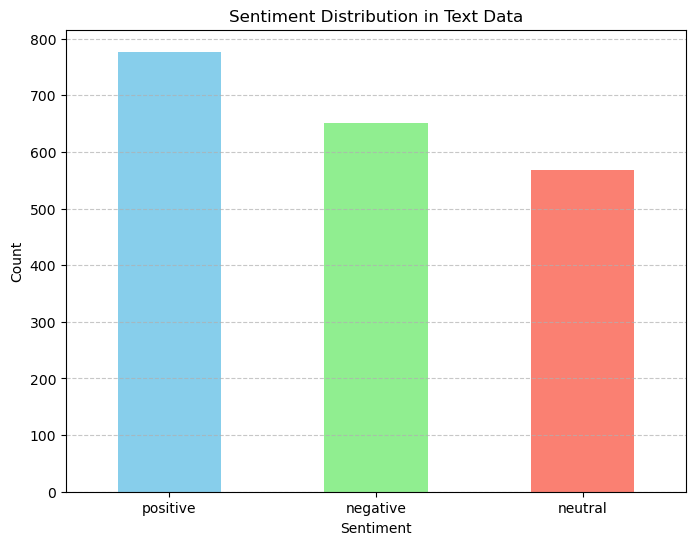

In [423]:
# Extract the overall sentiment from the sentiment analysis results
df['sentiment'] = df['sentiment'].apply(lambda x: 'positive' if x == 'positive' else 'negative' if x == 'negative' else 'neutral')

#plot the bar plot of the sentiment distribution
sentiment_counts = df['sentiment'].value_counts()
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Sentiment Distribution in Text Data')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
print(df.loc[430]['text'])

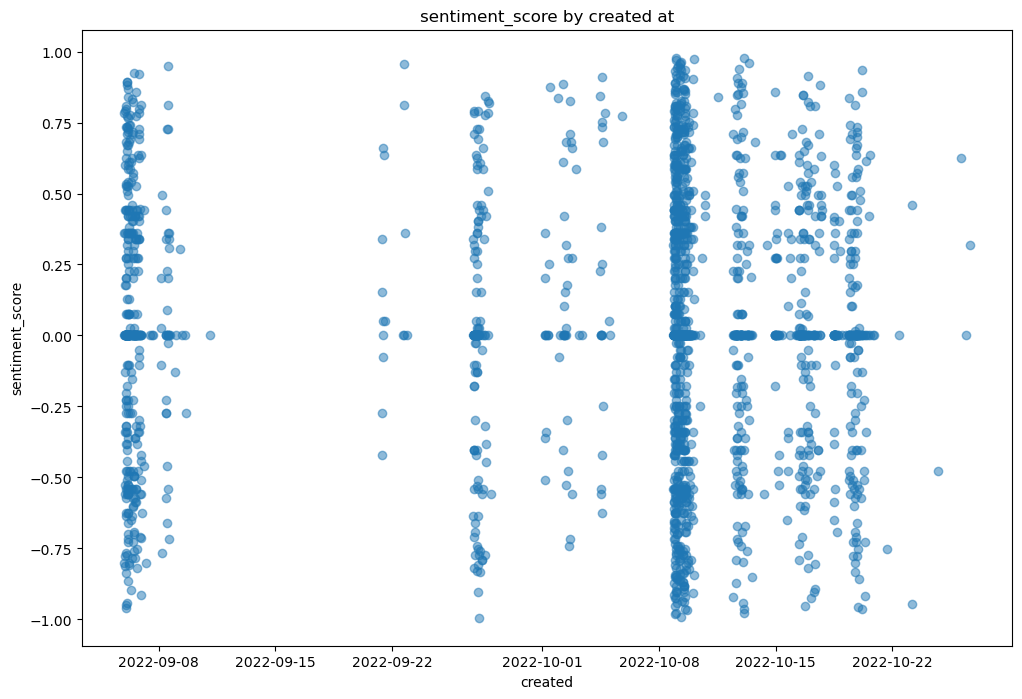

In [425]:
# scatter plot of sentiment_score by updated_at
plt.figure(figsize=(12, 8))
plt.scatter(df['created'], df['score'], alpha=0.5)
plt.xlabel('created')
plt.ylabel('sentiment_score')
plt.title('sentiment_score by created at')
plt.show()
